## Image Preprocessing

In [ ]:
import os
import cv2
import numpy as np

# Path to the directory containing the X-ray images
dataset_folder = r"KneeXray"


# Function to preprocess images
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Resize the image to a consistent size (e.g., 512x512)
    image = cv2.resize(image, (224, 224))
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Normalize pixel values to the range [0, 1]
    normalized_image = gray_image / 255.0
    
    # Apply Gaussian blur for noise reduction
    blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)
    
    # Perform contrast enhancement using histogram equalization
    enhanced_image = cv2.equalizeHist(np.uint8(blurred_image * 255))
    
    return enhanced_image

# Function to preprocess all images in a directory (including subdirectories)
def preprocess_images_in_directory(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            # If the item is a directory, recursively call the function
            preprocess_images_in_directory(filepath)
        elif filename.endswith(".jpg") or filename.endswith(".png"):
            # Preprocess the image
            preprocessed_image = preprocess_image(filepath)
            
            # Save the preprocessed image to the preprocessed folder
            relative_path = os.path.relpath(filepath, dataset_folder)
            preprocessed_image_path = os.path.join(preprocessed_folder, relative_path)
            os.makedirs(os.path.dirname(preprocessed_image_path), exist_ok=True)
            cv2.imwrite(preprocessed_image_path, preprocessed_image)

# Preprocess all images in the dataset folder (including subfolders)
for i in os.listdir(dataset_folder):
    preprocessed_folder = "PreprocessedValidation"
    os.makedirs(preprocessed_folder, exist_ok=True)
    preprocess_images_in_directory(dataset_folder+"/"+i)
    # Create a new directory to store preprocessed images
    





## Necessary Imports

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

## Load Dataset

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./PreprocessedAll5/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
print(df_train_kaggle.shape)

(9786, 2)


Text(0, 0.5, 'count')

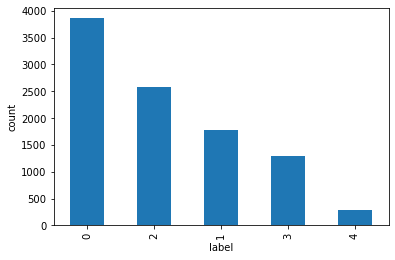

In [3]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

We can see that there is a class Imbalance in the data.

In [4]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


## Preparing validation and test data

In [6]:
compi_root_path= "./PreprocessedValidation/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,./PreprocessedValidation/train/Image_1.jpg,0
1,./PreprocessedValidation/train/Image_2.jpg,1
2,./PreprocessedValidation/train/Image_3.jpg,0
3,./PreprocessedValidation/train/Image_4.jpg,1
4,./PreprocessedValidation/train/Image_5.jpg,2


Text(0, 0.5, 'count')

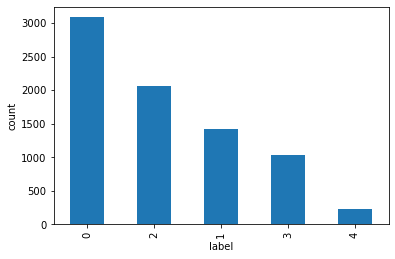

In [7]:
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [8]:


# Step 1: Split validation data into x_val and x_test
x_val, x_test = train_test_split(df_val_compi, test_size=0.35, random_state=42)

# Create separate generators for x_val and x_test
val_generator = valid_aug.flow_from_dataframe(
    dataframe=x_val,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

test_generator = valid_aug.flow_from_dataframe(
    dataframe=x_test,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)


Found 5088 validated image filenames.
Found 2740 validated image filenames.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Combine the base model with custom classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
hist=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
306/306 [==============================] - 105s 310ms/step - loss: 1.3956 - accuracy: 0.4000 - val_loss: 1.3552 - val_accuracy: 0.4367
Epoch 2/10
306/306 [==============================] - 56s 184ms/step - loss: 1.3367 - accuracy: 0.4295 - val_loss: 1.3031 - val_accuracy: 0.4509
Epoch 3/10
306/306 [==============================] - 59s 192ms/step - loss: 1.2915 - accuracy: 0.4514 - val_loss: 1.2554 - val_accuracy: 0.4627
Epoch 4/10
306/306 [==============================] - 60s 196ms/step - loss: 1.2500 - accuracy: 0.4652 - val_loss: 1.2283 - val_accuracy: 0.4833
Epoch 5/10
306/306 [==============================] - 61s 199ms/step - loss: 1.2335 - accuracy: 0.4714 - val_loss: 1.2061 - val_accuracy: 0.4896
Epoch 6/10
306/306 [==============================] - 61s 200ms/step - loss: 1.2133 - accuracy: 0.4770 - val_loss: 1.2072 - val_accuracy: 0.4774
Epoch 7/10
306/306 [==============================] - 62s 203ms/step - loss: 1.2064 - accuracy: 0.4844 - val_loss: 1.1950 - val_a

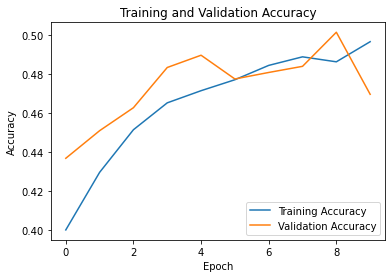

In [11]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 20s 235ms/step
Confusion Matrix:
[[1055    0   40    2    0]
 [ 451    0   41    0    0]
 [ 542    0  180    9    2]
 [ 187    0  119   27    3]
 [  19    0   24   16   23]]


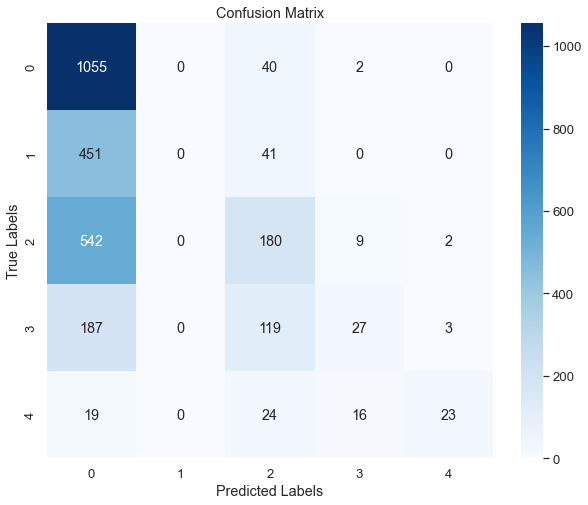

In [12]:
# Step 2: Use your model to predict labels for x_test
predictions = model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:

report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.96      0.63      1097
           1       0.00      0.00      0.00       492
           2       0.45      0.25      0.32       733
           3       0.50      0.08      0.14       336
           4       0.82      0.28      0.42        82

    accuracy                           0.47      2740
   macro avg       0.45      0.31      0.30      2740
weighted avg       0.39      0.47      0.37      2740



c:\Users\visha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\visha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\visha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
checkpoint_path = "vgg19_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
n_classes = 5  # Number of classes in your output
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
vgg19_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
vgg19_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

vgg19_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [17]:
history = vgg19_model.fit(
    train_generator,
    epochs=22,
    validation_data=val_generator,
    callbacks=[my_callbacks],
    class_weight=class_weights
)

Epoch 1/22
306/306 [==============================] - ETA: 0s - loss: 1.3652 - acc: 0.3182
Epoch 1: val_acc improved from -inf to 0.38188, saving model to vgg19_best.ckpt
306/306 [==============================] - 65s 203ms/step - loss: 1.3652 - acc: 0.3182 - val_loss: 1.4220 - val_acc: 0.3819 - lr: 1.0000e-05
Epoch 2/22
306/306 [==============================] - ETA: 0s - loss: 1.1712 - acc: 0.4365
Epoch 2: val_acc improved from 0.38188 to 0.48546, saving model to vgg19_best.ckpt
306/306 [==============================] - 66s 215ms/step - loss: 1.1712 - acc: 0.4365 - val_loss: 1.2561 - val_acc: 0.4855 - lr: 1.0000e-05
Epoch 3/22
306/306 [==============================] - ETA: 0s - loss: 1.0774 - acc: 0.4995
Epoch 3: val_acc improved from 0.48546 to 0.54068, saving model to vgg19_best.ckpt
306/306 [==============================] - 67s 220ms/step - loss: 1.0774 - acc: 0.4995 - val_loss: 1.1540 - val_acc: 0.5407 - lr: 1.0000e-05
Epoch 4/22
306/306 [==============================] - ETA:

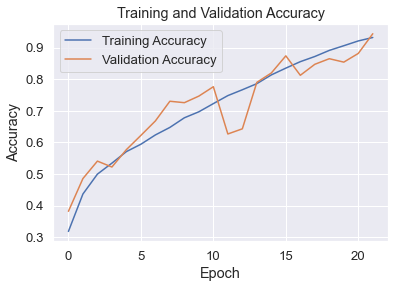

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [20]:
vgg19_model.load_weights(checkpoint_path)


86/86 [==============================] - 11s 127ms/step
Confusion Matrix:


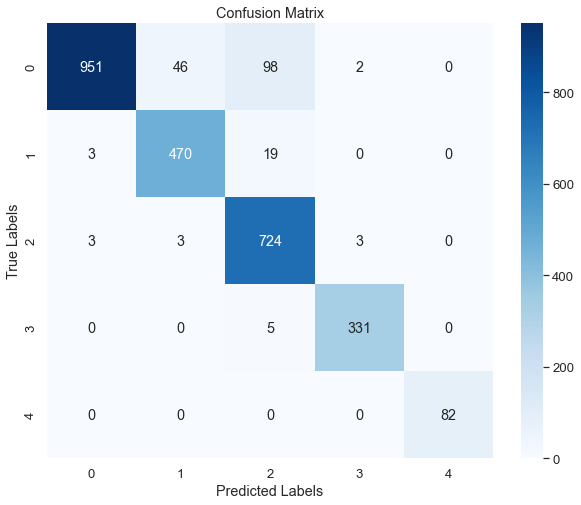

In [21]:
# Step 2: Use your model to predict labels for x_test
predictions = vgg19_model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:

report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1097
           1       0.91      0.96      0.93       492
           2       0.86      0.99      0.92       733
           3       0.99      0.99      0.99       336
           4       1.00      1.00      1.00        82

    accuracy                           0.93      2740
   macro avg       0.95      0.96      0.95      2740
weighted avg       0.94      0.93      0.93      2740



In [23]:
vgg19_model.save('vgg19_model.h5')

In [24]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu")(base_model.output)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

n_classes = 5  # Number of classes in your output
x = Conv2D(filters=n_classes, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)

# Global pooling layer
GAP = GlobalAveragePooling2D()(x)

# Output layer
pred = Dense(n_classes, activation='softmax')(GAP)

# Define the model
xception_model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [25]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [26]:
# train the model
history1 = xception_model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)


Epoch 1/20
306/306 [==============================] - ETA: 0s - loss: 1.4359 - acc: 0.3786
Epoch 1: val_acc improved from -inf to 0.43534, saving model to xception_best.ckpt
306/306 [==============================] - 66s 200ms/step - loss: 1.4359 - acc: 0.3786 - val_loss: 1.4486 - val_acc: 0.4353 - lr: 1.0000e-05
Epoch 2/20
306/306 [==============================] - ETA: 0s - loss: 1.2683 - acc: 0.4714
Epoch 2: val_acc improved from 0.43534 to 0.47602, saving model to xception_best.ckpt
306/306 [==============================] - 60s 197ms/step - loss: 1.2683 - acc: 0.4714 - val_loss: 1.3323 - val_acc: 0.4760 - lr: 1.0000e-05
Epoch 3/20
306/306 [==============================] - ETA: 0s - loss: 1.1698 - acc: 0.5187
Epoch 3: val_acc improved from 0.47602 to 0.54403, saving model to xception_best.ckpt
306/306 [==============================] - 60s 195ms/step - loss: 1.1698 - acc: 0.5187 - val_loss: 1.2653 - val_acc: 0.5440 - lr: 1.0000e-05
Epoch 4/20
306/306 [=============================

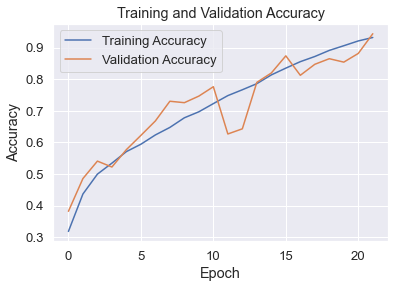

In [27]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 [==============================] - 12s 130ms/step
Confusion Matrix:


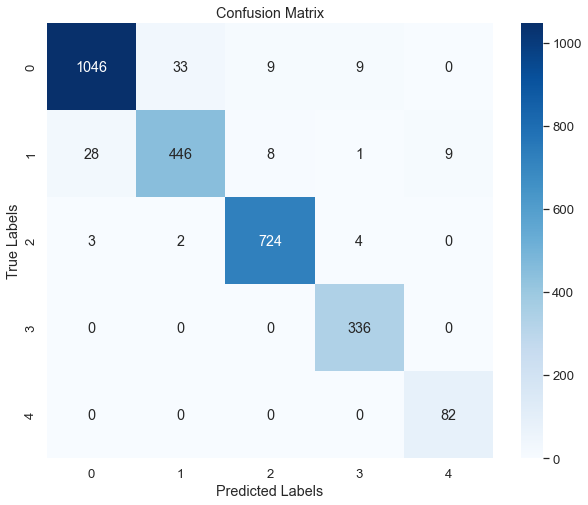

In [28]:

predictions = xception_model.predict(test_generator)

true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:

report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1097
           1       0.93      0.91      0.92       492
           2       0.98      0.99      0.98       733
           3       0.96      1.00      0.98       336
           4       0.90      1.00      0.95        82

    accuracy                           0.96      2740
   macro avg       0.95      0.97      0.96      2740
weighted avg       0.96      0.96      0.96      2740



In [30]:
xception_model.save('xception_model.h5')